In [91]:
import os
import os
os.environ["NUMPY_EXPERIMENTAL_DTYPE_API"] = "1"
import numpy as np
import matplotlib.pyplot as plt
import climlab
from climlab import constants as constants
import sys
import xarray as xr
import pdb
import copy as cp
import pandas as pd
from scipy import stats
from scipy import interpolate


In [92]:
# Pour fixer la taille de la police partout
import matplotlib as matplotlib
#matplotlib.rcParams['font.family'] = "normal"
#matplotlib.rcParams['size'] = 15
font = {'family' : 'Avenir',
        'size'   : 15}
matplotlib.rc('font', **font)

In [93]:
outpath='./figures/' # repertoire pour les figures, il faut le creer dans votre repertoire

In [94]:
units=r'W m$^{-2}$' # Unités puissance
emiss_s=1. # Emissivité surface
emiss_a=0.77 #Emissivité atmosphere
alb=.25 # Albedo surface
S0=1376. # in W/m2
sigma=5.6767E-08 #Stefan-Boltzmann
levels=np.arange(200,330,20)
levels=[298]
Tlims=[180,310]
Nz=30 # nombre de niveaux verticaux

In [95]:
levels

[298]

# SIMULATION CONTRÔLE

### Initialisation des paramètres

In [96]:
# Load the reference vertical temperature profile from the NCEP reanalysis
ncep_lev=np.load('npy/ncep_lev.npy')
ncep_T=np.load('npy/ncep_T.npy')+273.15

#  State variables (Air and surface temperature)
state = climlab.column_state(num_lev=30)

#  Fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)

#  Couple water vapor to radiation
rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)

# Creation d'un modele couplé avec rayonnement, convection et vapeur d'eau
rcm = climlab.couple([rad,h2o], name='Radiative-Equilibrium Model')
rcm2 = climlab.process_like(rcm) # creation d'un clone du modele rcm

In [97]:
#Atmosphere Reset
def atmosphere_reset():
    alb=.25 # Albedo surface
    global state,h2o,rad,rcm,rcm2
    #  State variables (Air and surface temperature)
    state = climlab.column_state(num_lev=30)

    #  Fixed relative humidity
    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)

    #  Couple water vapor to radiation
    rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)

    # Creation d'un modele couplé avec rayonnement, convection et vapeur d'eau
    rcm = climlab.couple([rad,h2o], name='Radiative-Equilibrium Model')
    rcm2 = climlab.process_like(rcm) # creation d'un clone du modele rcm

In [98]:
print(climlab.column_state(num_lev=30))

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.        , 202.68965517, 205.37931034, 208.06896552,
       210.75862069, 213.44827586, 216.13793103, 218.82758621,
       221.51724138, 224.20689655, 226.89655172, 229.5862069 ,
       232.27586207, 234.96551724, 237.65517241, 240.34482759,
       243.03448276, 245.72413793, 248.4137931 , 251.10344828,
       253.79310345, 256.48275862, 259.17241379, 261.86206897,
       264.55172414, 267.24137931, 269.93103448, 272.62068966,
       275.31034483, 278.        ])})


In [99]:
rcm.lev

array([ 16.66666667,  50.        ,  83.33333333, 116.66666667,
       150.        , 183.33333333, 216.66666667, 250.        ,
       283.33333333, 316.66666667, 350.        , 383.33333333,
       416.66666667, 450.        , 483.33333333, 516.66666667,
       550.        , 583.33333333, 616.66666667, 650.        ,
       683.33333333, 716.66666667, 750.        , 783.33333333,
       816.66666667, 850.        , 883.33333333, 916.66666667,
       950.        , 983.33333333])

### graphique - solution contrôle


 

********************************************
Control simulation 
********************************************
AttrDict({'Ts': Field([288.]), 'Tatm': Field([288., 288., 288., 288., 288., 288., 288., 288., 288., 288., 288.,
       288., 288., 288., 288., 288., 288., 288., 288., 288., 288., 288.,
       288., 288., 288., 288., 288., 288., 288., 288.])})


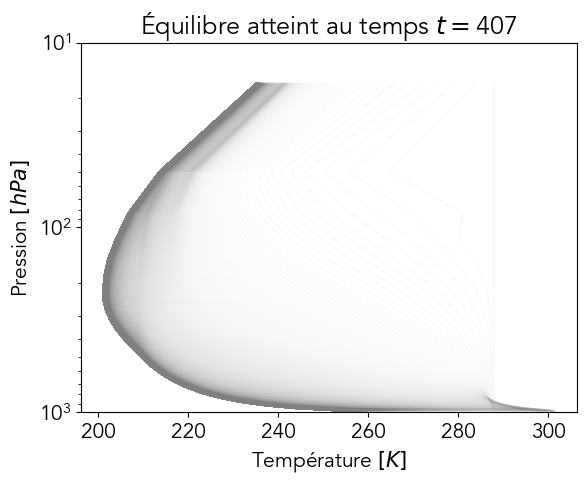

output figure:  ./figures/fig1.png


In [100]:
print('\n','\n')
print('********************************************')
print('Control simulation ')
print('********************************************')
# Make the initial state isothermal
rcm.state.Tatm[:] = rcm.state.Ts
T=[]
q=[]
tr=[]
print(state)
# Plot temperature
eq=0
for t in range(1000):
    T.append(cp.deepcopy(rcm.Tatm))
    q.append(cp.deepcopy(rcm.q))
    plt.plot(rcm.Tatm,rcm.lev[::], alpha=0.04, color="grey")
    rcm.step_forward() #run the model forward one time step
    
    #CONDITION D'ÉQUILIBRE
    if abs(rcm.ASR - rcm.OLR)<1:# in W/m2
        eq+=1
        tr.append(t)
        if eq==1:
            eq_Tatm = rcm.Tatm
            eq_lev = rcm.lev[::]
#             plt.plot(rcm.Tatm,rcm.lev[::-1], alpha=1, color="red", label="equilibrium")


plt.title(r'Équilibre atteint au temps $t=$'+str(tr[0]))
plt.xlabel(r'Température $[K]$')
plt.ylabel(r'Pression $[hPa]$')
plt.ylim([10,1000])
plt.gca().invert_yaxis()
plt.yscale('log')

fig_name=outpath+'fig1.png'
plt.savefig(fig_name,bbox_inches='tight')
plt.show()
plt.close()
print('output figure: ', fig_name)

### graphique - réanalyse ncep

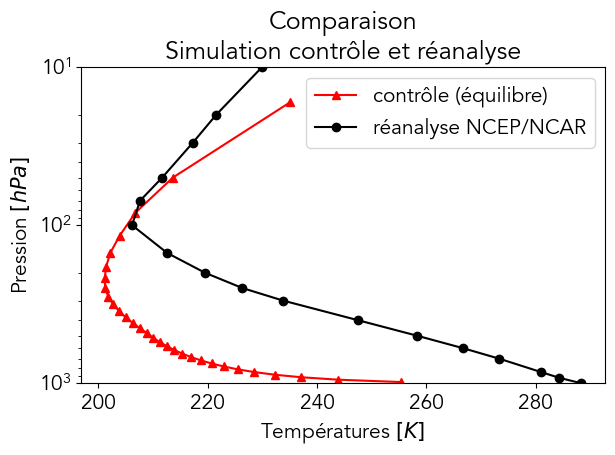

In [101]:
plt.plot(eq_Tatm,eq_lev,color="red",marker="^", label = "contrôle (équilibre)")
plt.plot(ncep_T,ncep_lev[::], color="black",marker="o", label = "réanalyse NCEP/NCAR")

plt.ylim([10,1000])
plt.yscale('log')
plt.xlabel(r"Températures $[K]$")
plt.ylabel(r"Pression $[hPa]$")
plt.title("Comparaison\nSimulation contrôle et réanalyse")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.legend()
plt.savefig(outpath+"1D_controle-VS-equilibre.png",dpi=300)
plt.show()

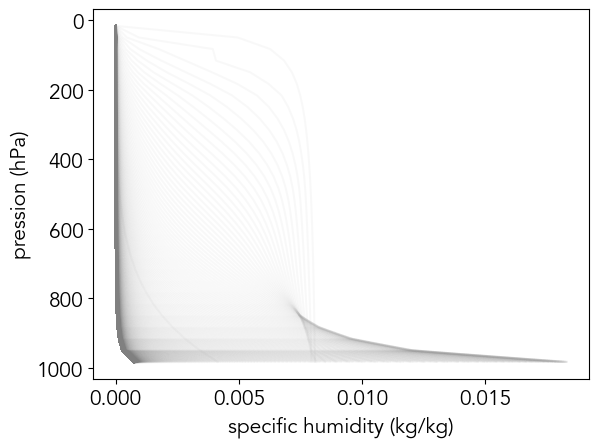

output figure:  ./figures/fig2.png

diagnostics:  {'OLR': Field([243.1363796]), 'OLRclr': Field([243.1363796]), 'OLRcld': Field([0.]), 'TdotLW': Field([-3.56209571, -0.75844777, -0.35741892, -0.26819342, -0.21639742,
       -0.18621983, -0.16427303, -0.14924665, -0.13994072, -0.13455319,
       -0.13125081, -0.1286825 , -0.12691451, -0.12510342, -0.12430928,
       -0.13075466, -0.13793417, -0.1457421 , -0.15508095, -0.16576379,
       -0.1775802 , -0.19241839, -0.21198472, -0.23771766, -0.27268611,
       -0.32247573, -0.39864447, -0.52564361, -0.76037454, -1.38073196]), 'TdotLW_clr': Field([-3.56209571, -0.75844777, -0.35741892, -0.26819342, -0.21639742,
       -0.18621983, -0.16427303, -0.14924665, -0.13994072, -0.13455319,
       -0.13125081, -0.1286825 , -0.12691451, -0.12510342, -0.12430928,
       -0.13075466, -0.13793417, -0.1457421 , -0.15508095, -0.16576379,
       -0.1775802 , -0.19241839, -0.21198472, -0.23771766, -0.27268611,
       -0.32247573, -0.39864447, -0.52564361, -

In [102]:
#Plot humidity
for t in range(1000):
    plt.plot(q[t],rcm.lev[::], color="grey", alpha=0.05)
plt.xlabel('specific humidity (kg/kg)')
plt.ylabel('pression (hPa)')
plt.gca().invert_yaxis()
fig_name=outpath+'fig2.png'
plt.savefig(fig_name,bbox_inches='tight')
plt.show()
plt.close()
print('output figure: ', fig_name)

# Quel est la sortie du modèle ?
print('\ndiagnostics: ',rcm.diagnostics,'\n')
print('\ntendencies',rcm.tendencies,'\n')
print('\nTair: ',rcm.Tatm,'\n')
print('\nalbedo',rcm.SW_flux_up[-1]/rcm.SW_flux_down[-1],'\n')
print('\nco2',rad.absorber_vmr['CO2'],'\n')
print('\nch4',rad.absorber_vmr['CH4'],'\n')


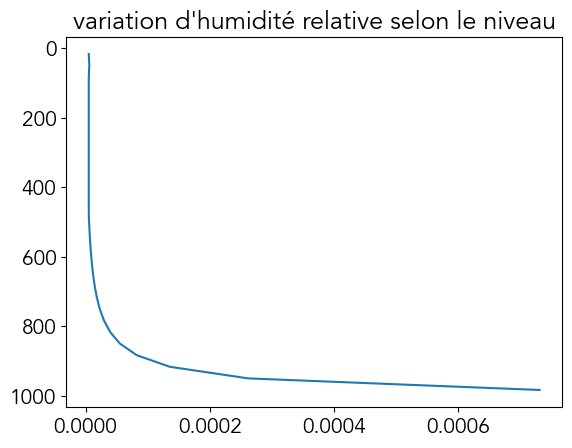

In [103]:
plt.plot(rcm.q, rcm.lev)
plt.gca().invert_yaxis()
plt.title("variation d'humidité relative selon le niveau")
plt.show()


# SIMULATION - SENSIBILITÉ AUX GAZ ATMOSPHÉRIQUES


 

********************************************
Sensitivity to the concentration of gases in the atmosphere
********************************************
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
output figure:  ./figures/fig3.png


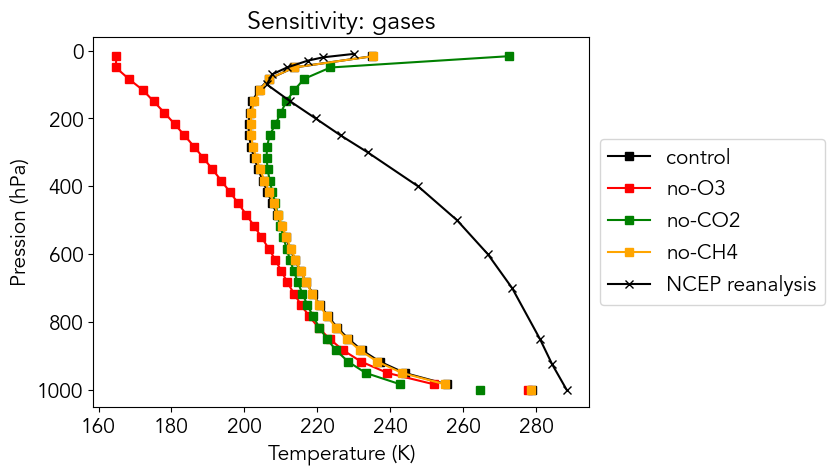

In [104]:

print('\n','\n')
print('********************************************')
print('Sensitivity to the concentration of gases in the atmosphere')
print('********************************************')
colors=['k','r','g','orange']
plt.plot(rcm.Tatm[::-1], rcm.lev[::-1], marker='s', color=colors[0],label='control')
plt.plot(rcm.Ts, 1000, marker='s',color=colors[0])

for gi,gg in enumerate(['O3','CO2','CH4']):
    state = climlab.column_state(num_lev=30)
    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
    rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
    rcm = climlab.couple([rad,h2o], name='Radiative-Convective Model')
    rcm.absorber_vmr[gg] = 0
    rcm.integrate_years(2) # Integre pour deux années
    plt.plot(rcm.Tatm[::-1], rcm.lev[::-1], marker='s', label='no-'+gg,color=colors[gi+1])
    plt.plot(rcm.Ts, 1000, marker='s',color=colors[gi+1])
plt.plot(ncep_T, ncep_lev, marker='x',color='k',label='NCEP reanalysis')
plt.gca().invert_yaxis()
plt.title('Sensitivity: gases')
plt.ylabel('Pression (hPa)')
plt.xlabel('Temperature (K)')
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig_name=outpath+'fig3.png'
print('output figure: ', fig_name)
plt.savefig(fig_name,bbox_inches='tight')
plt.show()
plt.close()

### Variations des gaz ( $O_3$, $CO_2$ ,$CH_4$)

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


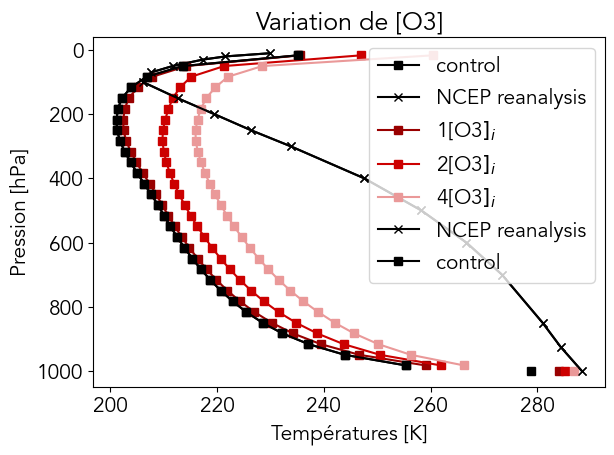

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


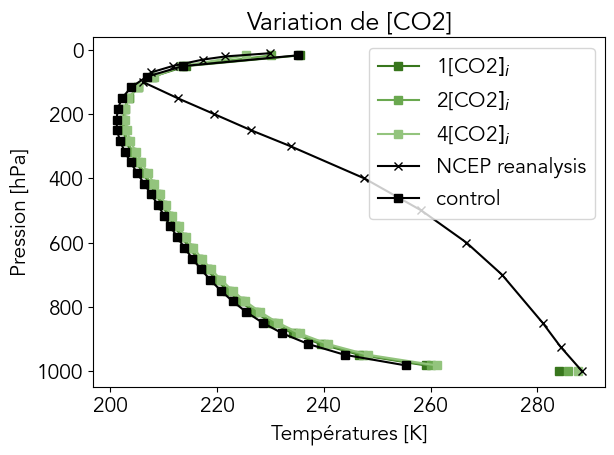

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


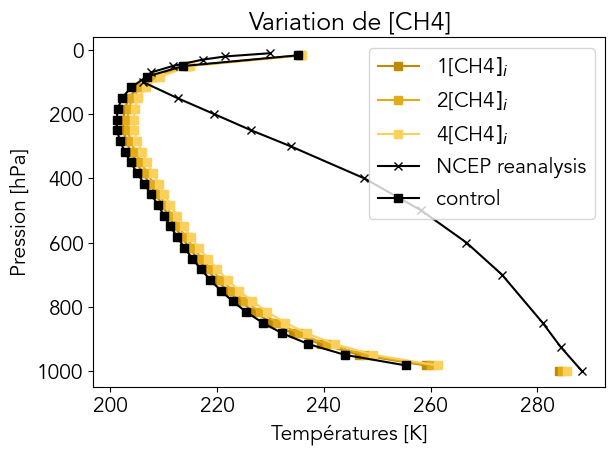

In [148]:
#Graph des valeurs contrôle et NCEP reanalysis
atmosphere_reset()
rcm.integrate_years(2)

plt.plot(rcm.Tatm[::], rcm.lev[::], marker='s', color="black",label='control')
plt.plot(rcm.Ts, 1000, marker='s',color='black')
plt.plot(ncep_T, ncep_lev, marker='x',color='black',label='NCEP reanalysis')

#Variations de l'O3
gas=['O3','CO2','CH4']

O3_colors =['#990000','#cc0000','#ea9999'] #Shades of red
CO2_colors=['#38761d','#6aa84f','#93c47d'] #Shades of green
CH4_colors=['#bf8900','#e3ab1a','#fdd05c'] #Shades of yellow
colors=[O3_colors,CO2_colors,CH4_colors]

for i,g in enumerate(gas):
    gas_colors = colors[i]
    
    #Plot concentration variations for gas[i]
    for index, variation in enumerate([1,2,4]):
        
        #Atmosphere reset
        state = climlab.column_state(num_lev=30)
        h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
        rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
        rcm = climlab.couple([rad,h2o], name='Radiative-Convective Model')
        
        #Gas variation
        rcm.absorber_vmr[g] = variation*rcm.absorber_vmr[g]
        
        #Time integration
        rcm.integrate_years(2) # Integre pour deux années
        
        #Plot params
        plt.plot(rcm.Tatm[::], rcm.lev[::], marker='s', 
                 label=f"{variation}[{g}"+r"$]_i$",
                 color=gas_colors[index])
        #Plot surface params
        plt.plot(rcm.Ts, 1000, marker='s',color=gas_colors[index])
        
    plt.plot(ncep_T, ncep_lev, marker='x',color='black',label='NCEP reanalysis')
    atmosphere_reset()
    rcm.integrate_years(2)

    plt.plot(rcm.Tatm[::], rcm.lev[::], marker='s', color="black",label='control')
    plt.gca().invert_yaxis()
    plt.title(f'Variation de [{g}]')
    plt.xlabel("Températures [K]")
    plt.ylabel("Pression [hPa]")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"figures/var_n{g}_M1DEqRad.png",dpi=300)
    plt.show()
    
    
    

### Variations de dioxyde de carbone ( $CO_2$ ) par rapport à l'ère pré-industrielle

In [13]:
atmosphere_reset()
rcm.absorber_vmr["CO2"]

0.000348

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


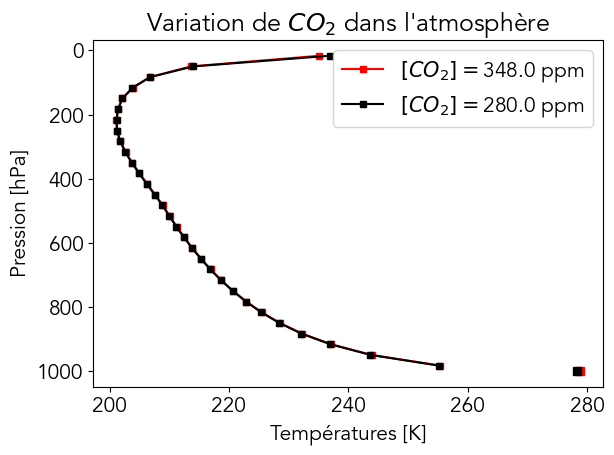

In [108]:
#Atmosphere reset
atmosphere_reset()

for pos,concentration in enumerate([0.000348,0.000280]): #Valeurs actuelles, pré-industrielles
    #Atmosphere reset
    state = climlab.column_state(num_lev=30)
    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
    rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
    rcm = climlab.couple([rad,h2o], name='Radiative-Convective Model')

    #Gas variation
    rcm.absorber_vmr["CO2"] = concentration

    #Time integration
    rcm.integrate_years(2) # Integre pour deux années

    #Plot params
    plt.plot(rcm.Tatm[::], rcm.lev[::], marker='s',
             markersize=5 ,
             label=r"$[CO_2]=$"+f"{concentration*1E6} ppm",
             color=["red","black"][pos])
    #Plot surface params
    plt.plot(rcm.Ts, 1000, marker='s',color=["red","black"][pos])
    
plt.gca().invert_yaxis()
plt.title(f'Variation de '+r'$CO_2$'+' dans l\'atmosphère')
plt.xlabel("Températures [K]")
plt.ylabel("Pression [hPa]")

plt.legend()
plt.tight_layout()
plt.savefig("./figures/1D_CO2_modVpi.png", dpi=300)
plt.show()

### Variations de méthane ( $CH_4$ )  par rapport à l'ère pré-industrielle

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


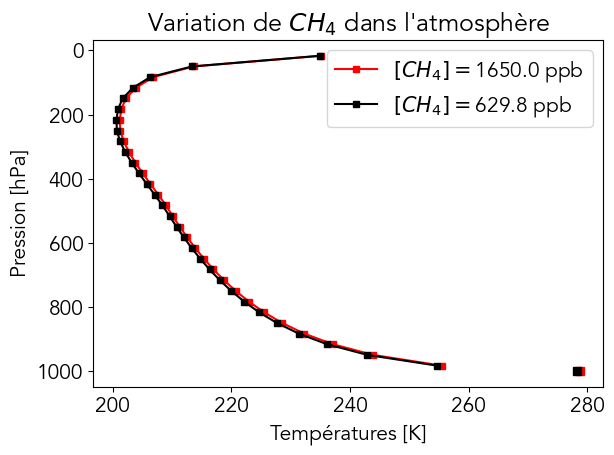

In [109]:
#Atmosphere reset
atmosphere_reset() #Corrige valeurs de départ de la boucle si je redémarre la cellule
for pos,concentration in enumerate([rcm.absorber_vmr["CH4"],(1/2.62)*rcm.absorber_vmr["CH4"]]): #Valeurs actuelles, pré-industrielles
    #Atmosphere reset
    state = climlab.column_state(num_lev=30)
    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
    rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
    rcm = climlab.couple([rad,h2o], name='Radiative-Convective Model')

    #Gas variation
    rcm.absorber_vmr["CH4"] = concentration

    #Time integration
    rcm.integrate_years(2) # Integre pour deux années

    #Plot params
    plt.plot(rcm.Tatm[::], rcm.lev[::], marker='s',
             markersize=5 ,
             label=r"$[CH_4]=$"+f"{round(concentration*1E9,1)} ppb",
             color=["red","black"][pos])
    #Plot surface params
    plt.plot(rcm.Ts, 1000, marker='s',color=["red","black"][pos])
    
plt.gca().invert_yaxis()
plt.title(f'Variation de '+r'$CH_4$'+' dans l\'atmosphère')
plt.xlabel("Températures [K]")
plt.ylabel("Pression [hPa]")
plt.legend()
plt.tight_layout()
plt.savefig("./figures/1D_CH4_modVpi.png", dpi=300)
plt.show()

### Variations d'ozone ( $O_3$ )  par rapport à l'ère pré-industrielle

In [16]:
rcm.lev

array([ 16.66666667,  50.        ,  83.33333333, 116.66666667,
       150.        , 183.33333333, 216.66666667, 250.        ,
       283.33333333, 316.66666667, 350.        , 383.33333333,
       416.66666667, 450.        , 483.33333333, 516.66666667,
       550.        , 583.33333333, 616.66666667, 650.        ,
       683.33333333, 716.66666667, 750.        , 783.33333333,
       816.66666667, 850.        , 883.33333333, 916.66666667,
       950.        , 983.33333333])

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


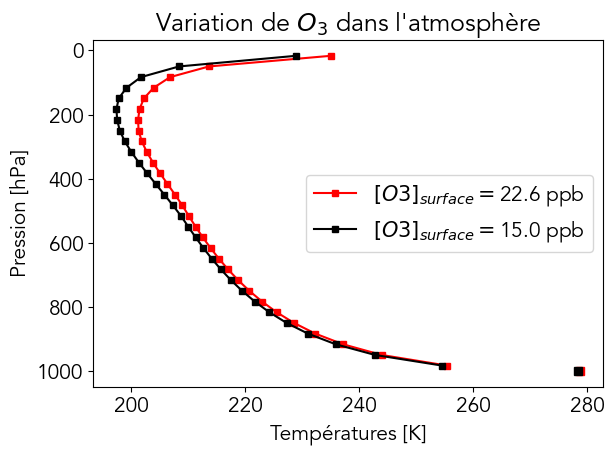

In [110]:
#Atmosphere reset
atmosphere_reset()
for pos,concentration in enumerate([rcm.absorber_vmr["O3"],(1/1.5)*rcm.absorber_vmr["O3"]]): #Valeurs actuelles, pré-industrielles
    #Atmosphere reset
    state = climlab.column_state(num_lev=30)
    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
    rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
    rcm = climlab.couple([rad,h2o], name='Radiative-Convective Model')

    #Gas variation
    rcm.absorber_vmr["O3"] = concentration

    #Time integration
    rcm.integrate_years(2) # Integre pour deux années

    #Plot params
    plt.plot(rcm.Tatm[::], rcm.lev[::], marker='s',
             markersize=5 ,
             label=r"$[O3]_{surface}=$"+f"{round(concentration[-1]*1E9,1)} ppb",
             color=["red","black"][pos])
    #Plot surface params
    plt.plot(rcm.Ts, 1000, marker='s',color=["red","black"][pos])
    
plt.gca().invert_yaxis()
plt.title(f'Variation de '+r'$O_3$'+' dans l\'atmosphère')
plt.xlabel("Températures [K]")
plt.ylabel("Pression [hPa]")
plt.legend()
plt.tight_layout()
plt.savefig("./figures/1D_O3_modVpi.png", dpi=300)
plt.show()

# SIMULATION - SENSIBILITÉ À L'ALBÉDO

In [18]:
np.arange(.1,.4,.1)

array([0.1, 0.2, 0.3, 0.4])


 

********************************************
Sensitivity to albedo
********************************************
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
output figure:  ./figures/1D_TvsAlb.png


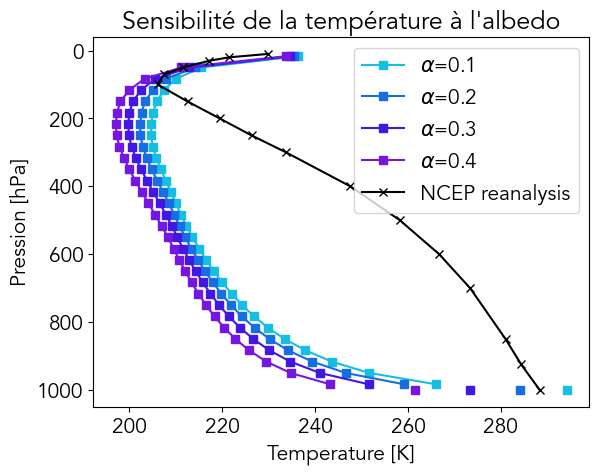

In [113]:
print('\n','\n')
print('********************************************')
print('Sensitivity to albedo')
print('********************************************')
albedos=np.arange(.1,.4,.1)
rcms={}
alb_colors=["#16bee3","#166ee3","#4216e3","#7516e3"]
for alb in albedos:
    state = climlab.column_state(num_lev=30)
    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
    rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
    rcm = climlab.couple([rad,h2o], name='Radiative-Convective Model')
    rcms['rcm'+str(alb)]=rcm

for ai,alb in enumerate(albedos):
    rcms['rcm'+str(alb)].integrate_years(2)
    
    plt.plot(rcms['rcm'+str(alb)].Tatm[::], 
             rcm.lev[::], marker='s', 
             label=r'$\alpha$='+str(np.round(alb,1)),
             color=alb_colors[ai])
    
    plt.plot(rcms['rcm'+str(alb)].Ts, 
             1000, 
             marker='s',
             color=alb_colors[ai])
    
plt.plot(ncep_T, ncep_lev, marker='x',color='k',label='NCEP reanalysis')
plt.gca().invert_yaxis()
plt.title('Sensibilité de la température à l\'albedo')
plt.ylabel('Pression [hPa]')
plt.xlabel('Temperature [K]')
plt.gca().legend()
fig_name=outpath+'1D_TvsAlb.png'
print('output figure: ', fig_name)
plt.savefig(fig_name,bbox_inches='tight')
plt.show()
plt.close()

### BIO-INGÉNIERIE : COMPENSER L'AUGMENTATION DE $CO_2$ AVEC L'ALBÉDO DE SURFACE

In [20]:
np.arange(.1,.4,.05)

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ])

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986

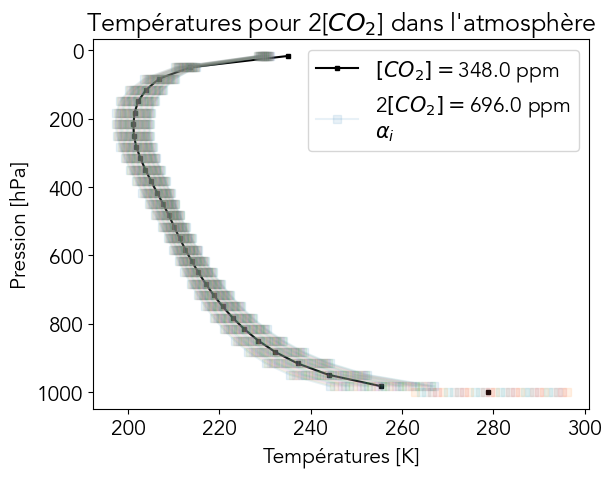

In [115]:
#atmosphere reset
atmosphere_reset()

# #Gas variation
# rcm.absorber_vmr["CO2"] = 2*rcm.absorber_vmr["CO2"]

#Time integration
rcm.integrate_years(2) # Integre pour deux années

#Plot params
plt.plot(rcm.Tatm[::], rcm.lev[::], marker='s',markersize=3,
         label=r"$[CO_2]=$"+f"{rcm.absorber_vmr['CO2']*1E6} ppm",
         color="black")

#Plot surface params
plt.plot(rcm.Ts, 1000, marker='s',markersize=3,color=["red","black"][pos])

#Sauvegarde de la température de référence
ref_T=np.array(rcm.Tatm)
#Ajout des variations d'albédo
albedos=np.arange(.1,.4,.01)
rcms={}

# Dictionnaire des différences de température entre le T_ref 
# et les T selon les variations d'albédo avec le double de CO2
diff_T={}

#Loop de simulations avec variations d'albédo
for alb in albedos:
    state = climlab.column_state(num_lev=30)
    h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
    # rad en fonction de l'albédo choisit
    rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
    
    rcm = climlab.couple([rad,h2o], name='Radiative-Convective Model')
    #rcm avec le double de CO2 initial
    rcm.absorber_vmr["CO2"]=2*rcm.absorber_vmr["CO2"]
    
    rcms['rcm'+str(alb)]=rcm
iteration=0
for ai,alb in enumerate(albedos):
    iteration+=1
    #Intégration sur 2 ans
    rcms['rcm'+str(alb)].integrate_years(2)
    
    #Plus petite différence moyenne entre le profil de Tatm à CO2 double et de Tatm à CO2 simple et albédo 
    diff_T[str(alb)]=abs(np.mean(ref_T-rcms['rcm'+str(alb)].Tatm))
    
    if iteration == 1:
        plt.plot(rcms['rcm'+str(alb)].Tatm[::], 
                 rcm.lev[::], marker='s',
                 alpha = 0.1, label=r"2$[CO_2]=$"+f"{rcm.absorber_vmr['CO2']*1E6} ppm\n"+r"$\alpha_i$")

        plt.plot(rcms['rcm'+str(alb)].Ts, 
                 1000, 
                 marker='s',
                 alpha = 0.1)
    else:
        plt.plot(rcms['rcm'+str(alb)].Tatm[::], 
                 rcm.lev[::], marker='s',
                 alpha = 0.1)

        plt.plot(rcms['rcm'+str(alb)].Ts, 
                 1000, 
                 marker='s',
                 alpha = 0.1)
  
# plt.plot(rcm.Ts, 
#              1000, 
#              marker='s',
#              alpha = 0.5)
    
plt.gca().invert_yaxis()
plt.title(r'Températures pour 2[$CO_2$]'+' dans l\'atmosphère')
plt.xlabel("Températures [K]")
plt.ylabel("Pression [hPa]")
plt.legend()

fig_name=outpath+'1D_CO2vsAlb.png'
print('output figure: ', fig_name)
plt.savefig(fig_name,bbox_inches='tight')

plt.show()

In [22]:
min_alb = min(diff_T, key=diff_T.get)
min_alb

'0.24999999999999992'

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
output figure:  ./figures/1D_CO2vsAlb_bestGuess.png


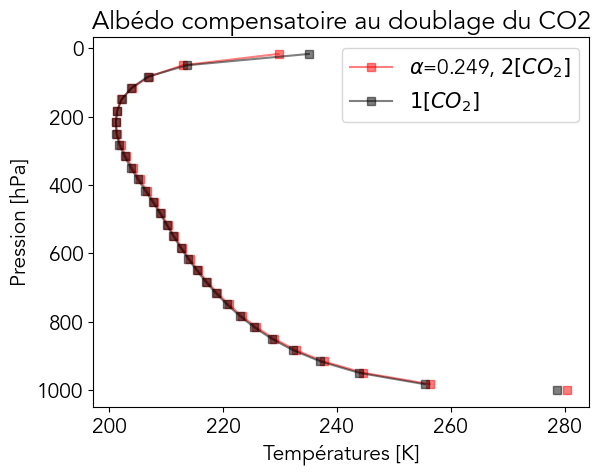

In [116]:

#Plot closest match
#Identifier l'albédo qui a créé le champ de température verticales
#le plus proche de celui avec le CO2 normal

min_alb=round(float(min(diff_T,key=diff_T.get)),3)

#Reset spécifique à cet albédo de l'atmosphère, avec le double de CO2

state = climlab.column_state(num_lev=30)
h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
# rad en fonction de l'albédo choisit
rad = climlab.radiation.RRTMG(
    name='Radiation', 
    state=state, 
    specific_humidity=h2o.q, 
    albedo=min_alb)

rcm = climlab.couple([rad,h2o], name='Radiative-Convective Model')
#rcm avec le double de CO2 initial
rcm.absorber_vmr["CO2"]=2*rcm.absorber_vmr["CO2"]

rcm.integrate_years(2)

#Plot du profil de température avec le double de C02, et l'albédo pour compenser le changement de température 
plt.plot(rcm.Tatm[::], 
             rcm.lev[::], marker='s', 
             label=r"$\alpha$="+f"{0.249}, "+r'$2[CO_2]$',
             alpha = .5,
            color="red")

plt.plot(rcm.Ts, 
             1000, marker='s', 
             alpha = .5,
             color="red")

#Plot du profil de référence, avec CO2 simple
atmosphere_reset()
rcm.integrate_years(2)
plt.plot(rcm.Tatm[::], 
             rcm.lev[::], marker='s', 
             label=r"$1[CO_2]$",
             alpha = .5,
            color="black")

plt.plot(rcm.Ts, 
             1000, marker='s', 
             alpha = .5,
             color="black")

plt.gca().invert_yaxis()
plt.title(r'Albédo compensatoire au doublage du CO2')
plt.xlabel("Températures [K]")
plt.ylabel("Pression [hPa]")
plt.legend()

fig_name=outpath+'1D_CO2vsAlb_bestGuess.png'
print('output figure: ', fig_name)
plt.savefig(fig_name,bbox_inches='tight')

plt.show()

# SENSIBILITÉ À LA CONVECTION


 

********************************************
Sensitivity to convection
********************************************
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
output figure:  ./figures/fig5.png


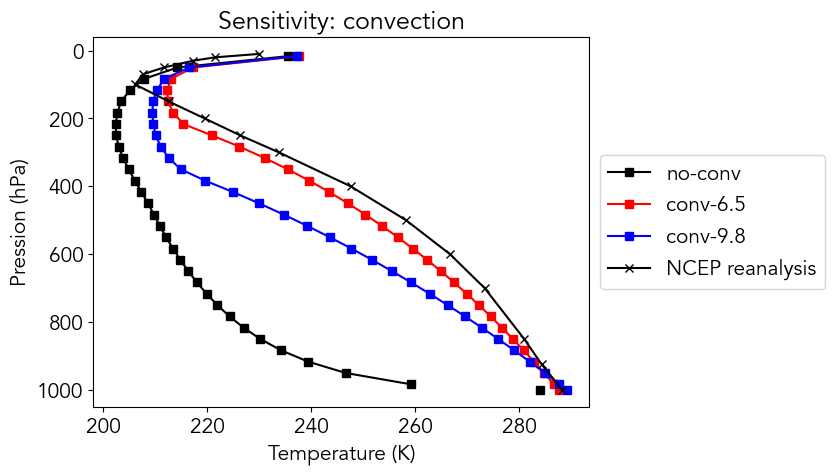

In [24]:
# print('\n','\n')
# print('********************************************')
# print('Sensitivity to convection')
# print('********************************************')
alb=.2
state = climlab.column_state(num_lev=30)
h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
rcms={}
rcms['rcm0'] = climlab.couple([rad,h2o], name='Radiative-Convective Model')
conv = climlab.convection.ConvectiveAdjustment(name='Convection', state=state, adj_lapse_rate=6.5)
rcms['rcm1'] = climlab.couple([rad,conv,h2o], name='Radiative-Convective Model')
conv = climlab.convection.ConvectiveAdjustment(name='Convection', state=state, adj_lapse_rate=9.8) #lapse rate in degC per km
rcms['rcm2'] = climlab.couple([rad,conv,h2o], name='Radiative-Convective Model')

mod_name=['no-conv','conv-6.5','conv-9.8']
colors=["black","red","blue"]
for ai in range(3):
    rcms['rcm'+str(ai)].integrate_years(2)
    plt.plot(rcms['rcm'+str(ai)].Tatm[::-1], rcm.lev[::-1], marker='s', label=mod_name[ai],color=colors[ai])
    plt.plot(rcms['rcm'+str(ai)].Ts, 1000, marker='s',color=colors[ai])
plt.plot(ncep_T, ncep_lev, marker='x',color='k',label='NCEP reanalysis')
plt.gca().invert_yaxis()
plt.title('Sensitivity: convection')
plt.ylabel('Pression (hPa)')
plt.xlabel('Temperature (K)')
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig_name=outpath+'fig5.png'
print('output figure: ', fig_name)
# plt.savefig(fig_name,bbox_inches='tight')
plt.show()
plt.close()

### expérience : variations pour 20 taux de convection

In [25]:

alb=.2
state = climlab.column_state(num_lev=30)
h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)
rcms_conv={}

In [26]:
list(rcms_conv.keys())

[]

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
<class 'list'>
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
<class 'list'>
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
<class 'list'>
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
<class 'list'>
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
<class 'list'>
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
<class 'list'>
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
<class 'list'>
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.
<class 'list'>
Integrating for 730 steps, 730.4844 days, or 2 years.
Total elap

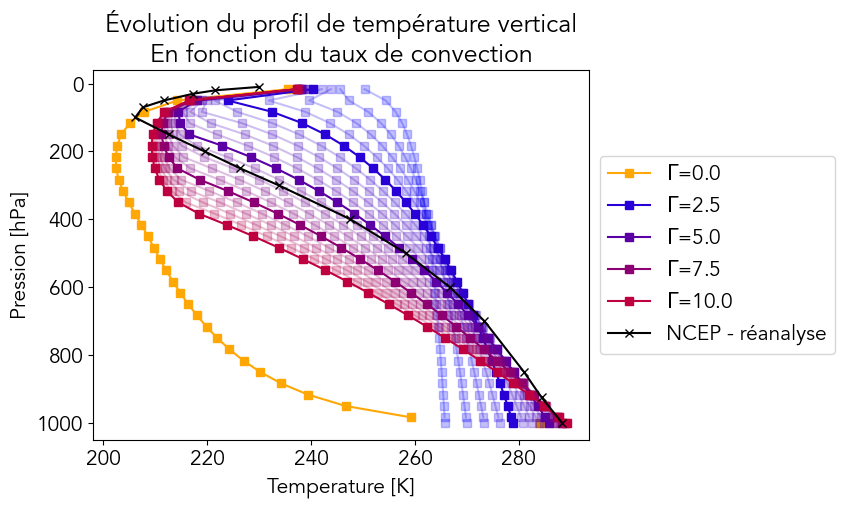

In [117]:
#Atmosphere set-up
alb=.2
state = climlab.column_state(num_lev=30)
h2o = climlab.radiation.ManabeWaterVapor(name='WaterVapor', state=state)
rad = climlab.radiation.RRTMG(name='Radiation', state=state, specific_humidity=h2o.q, albedo=alb)


#rcm pour chaque convection rate
conv_rates = np.arange(0,10.1,.5)

rcms_conv={}
colors = [
    "#ffa705","#0000FF", "#0A00F5", "#1400EB", "#1E00E1", "#2800D7", "#3200CD", "#3C00C3", 
    "#4600B9", "#5000AF", "#5A00A5", "#64009B", "#6E0091", "#780087", "#82007D", 
    "#8C0073", "#960069", "#A0005F", "#AA0055", "#B4004B", "#BE0041", "#C80037", 
    "#D2002D", "#DC0023", "#E60019", "#F0000F", "#FA0005", "#FF0A00", "#FF1400", 
    "#FF1E00", "#FF2800", "#FF3200"
]
#Création d'un rcm pour chaque taux de convection
for rate in conv_rates :
    if rate == 0:
        rcms_conv["c-"+str(rate)] = climlab.couple([rad,h2o], name='Radiative-Convective Model')
    else:
        conv = climlab.convection.ConvectiveAdjustment(
                name = 'Convection', 
                state = state, 
                adj_lapse_rate = rate)

        rcms_conv["c-"+str(rate)] = climlab.couple([rad,conv,h2o], name='Radiative-Convective Model')

#Tatm et Ts pour chaque convection rate
rcms_Tprofile={}

for ri, rate in enumerate(list(rcms_conv.keys())) :
    rcms_conv[rate].integrate_years(2)
    
    rcms_Tprofile[rate]=list(rcms_conv[rate].Tatm[::])
    rcms_Tprofile[rate].append(list(rcms_conv[rate].Ts[::])[0])
    #Plot des profils
    if ri in [0,5,10,15,20]:
        plt.plot(rcms_conv[rate].Tatm[::],rcm.lev, marker='s',
                 label=r'$\Gamma$='+f"{rate.split('-')[1]}", color=colors[ri])
        plt.plot(rcms_conv[rate].Ts,1000, marker='s', color=colors[ri])
    else:
        plt.plot(rcms_conv[rate].Tatm[::],rcm.lev, marker='s', color=colors[ri], alpha=0.25)
        plt.plot(rcms_conv[rate].Ts,1000, marker='s', color=colors[ri], alpha=0.25)

    
    print(type(list(rcms_conv[rate].Ts[::])))
    
# conv_rate_values = np.array(list(rcms_Tprofile.values()))
# conv_rate_columns = np.array(list(rcms_Tprofile.keys()))
# data=pd.DataFrame(rcms_Tprofile)
# data.to_csv("../../conv_rates_data.csv", index=True)

#Ajout de l'analyse NCEP
plt.plot(ncep_T, ncep_lev, marker='x',color='k',label='NCEP - réanalyse')

#Params de graphique
plt.gca().invert_yaxis()
plt.title('Évolution du profil de température vertical\nEn fonction du taux de convection')
plt.ylabel('Pression [hPa]')
plt.xlabel('Temperature [K]')
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig_name=outpath+'1D_Tz_F_Gamma.png'
print('output figure: ', fig_name)
plt.savefig(fig_name,bbox_inches='tight')
plt.show()
plt.close()

In [118]:
rcms_TprofileArray = np.array(list(rcms_Tprofile.values()))
# array des profils de températures, du haut vers le bas, 
# pour les 21 valeurs de convection entre 0 et 10 (inclus)

# référencement : 
# rcms_TprofileArray [Taux convection (indices 0 à 20)] [temp(z)]

len(rcms_TprofileArray)


21

### Moyenne des différences de température entre deux profils verticaux pour un $\Gamma_n$ et un $\Gamma_{n+1}$

In [119]:
# Moyenne des différences de températures entre deux taux de conversion
Gamma_list = list(rcms_Tprofile.keys())
#On exclut Gamma = 0, le modèle sans convection
Gamma_MoyTvar=[]
for taux in range(1,20):
    
    delta_T_array = abs((rcms_TprofileArray[taux]-rcms_TprofileArray[taux+1])/rcms_TprofileArray[taux])
#     print(delta_T_array)
    delta_T_mean = np.mean(delta_T_array)
#     print(delta_T_mean)
    Gamma_MoyTvar.append([
        float(Gamma_list[taux+1].split('-')[1]),
        delta_T_mean])
    
GMTv_array = np.array(Gamma_MoyTvar) 
GMTv_array[:]

array([[1.00000000e+00, 1.01968681e-02],
       [1.50000000e+00, 8.92764190e-03],
       [2.00000000e+00, 8.63360527e-03],
       [2.50000000e+00, 8.53114867e-03],
       [3.00000000e+00, 7.76376107e-03],
       [3.50000000e+00, 7.81215605e-03],
       [4.00000000e+00, 7.34222268e-03],
       [4.50000000e+00, 7.16067917e-03],
       [5.00000000e+00, 6.98503756e-03],
       [5.50000000e+00, 6.54416122e-03],
       [6.00000000e+00, 6.33756414e-03],
       [6.50000000e+00, 6.17722386e-03],
       [7.00000000e+00, 5.81468415e-03],
       [7.50000000e+00, 5.57114062e-03],
       [8.00000000e+00, 5.42305179e-03],
       [8.50000000e+00, 5.00698358e-03],
       [9.00000000e+00, 4.83042497e-03],
       [9.50000000e+00, 4.67074461e-03],
       [1.00000000e+01, 4.28094654e-03]])

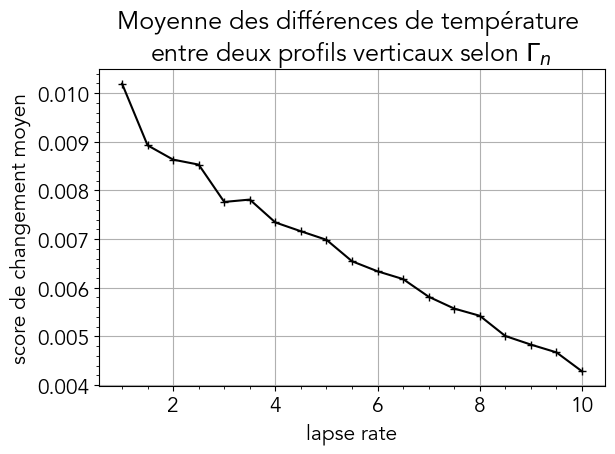

In [139]:
plt.plot(GMTv_array[:,0],GMTv_array[:,1], marker="+", color="black")
#TODO
plt.xlabel("lapse rate")
plt.ylabel("score de changement moyen")
plt.title(r"Moyenne des différences de température "+"\n"+"entre deux profils verticaux selon $\Gamma_n$ ")
plt.grid()
plt.minorticks_on()
plt.tight_layout()
plt.savefig("./figures/M1Der_stat1.png",dpi=300)

plt.show()

plt.close()

### Sensibilité au changement de $\Gamma$ en fonction du niveau $z$

In [31]:
rcms_TprofileArray[:,1]

array([214.26959446, 254.35721004, 247.25955403, 239.63257771,
       231.84029479, 223.9561023 , 221.45911448, 219.91127527,
       219.0671118 , 218.44870528, 218.00609855, 217.70418185,
       217.45869671, 217.26181094, 217.10376966, 216.97002114,
       216.84487999, 216.74917642, 216.6562286 , 216.57587181,
       216.50684348])

In [32]:
len(rcm.lev)

30

In [33]:

#Liste des écarts-types à chaque niveau
lev_Tstd=[]
for niveau in range(1,30):
    
    lev_std_array = np.std(rcms_TprofileArray[:,niveau])
    lev_Tstd.append([
        rcm.lev[niveau],
        lev_std_array
    ])
# print(lev_Tstd)
lev_Tstd_array=np.array(lev_Tstd)
   

In [34]:
# lev_Tstd_array[:,0]

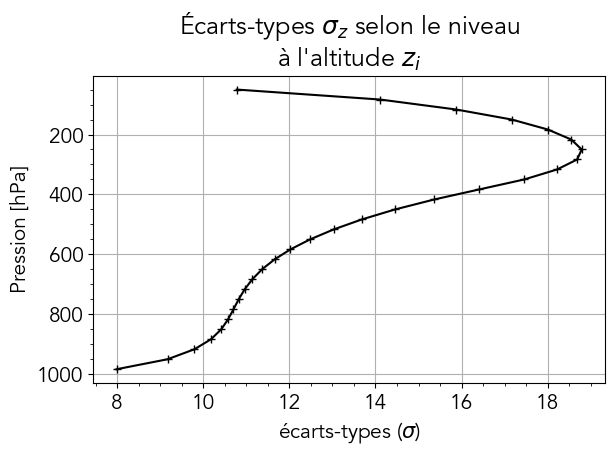

In [143]:
plt.plot(lev_Tstd_array[:,1], lev_Tstd_array[:,0], marker="+", color="black")
#TODO
plt.title(r"Écarts-types $\sigma_z$ selon le niveau"+"\n"+"à l'altitude $z_i$")
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel(r'écarts-types ($\sigma$)')
plt.ylabel('Pression [hPa]')
plt.minorticks_on()
plt.tight_layout()
plt.savefig("./figures/M1Der_stat2.png",dpi=300)

plt.show()
plt.close()

### Variance verticale selon le taux de convection $\Gamma$ 

In [36]:
rcms_TprofileArray[0]

array([235.51901744, 214.26959446, 207.89878945, 205.12554892,
       203.45241503, 202.69938416, 202.41764794, 202.46697347,
       202.97197847, 203.82556787, 204.88604185, 206.08532031,
       207.34223091, 208.59823691, 209.72781032, 210.87176211,
       212.09403863, 213.40911761, 214.82350022, 216.35690541,
       218.03142548, 219.88298688, 221.95034884, 224.29151561,
       227.00002668, 230.22537657, 234.21276048, 239.41453177,
       246.63018653, 259.13386275, 284.06356452])

In [37]:
#On exclut Gamma = 0, le modèle sans convection
Gamma_Vstd=[] #Écart-type par profil vertical pour chaque taux Gamma

for taux in range(1,21):
    
    Vstd = np.std(rcms_TprofileArray[taux])
#     print(delta_T_array)
    
    Gamma_Vstd.append([
        float(Gamma_list[taux].split('-')[1]),
        delta_T_mean])
    
Vstd_array = np.array(Gamma_MoyTvar) 
Vstd_array

array([[1.00000000e+00, 1.01968681e-02],
       [1.50000000e+00, 8.92764190e-03],
       [2.00000000e+00, 8.63360527e-03],
       [2.50000000e+00, 8.53114867e-03],
       [3.00000000e+00, 7.76376107e-03],
       [3.50000000e+00, 7.81215605e-03],
       [4.00000000e+00, 7.34222268e-03],
       [4.50000000e+00, 7.16067917e-03],
       [5.00000000e+00, 6.98503756e-03],
       [5.50000000e+00, 6.54416122e-03],
       [6.00000000e+00, 6.33756414e-03],
       [6.50000000e+00, 6.17722386e-03],
       [7.00000000e+00, 5.81468415e-03],
       [7.50000000e+00, 5.57114062e-03],
       [8.00000000e+00, 5.42305179e-03],
       [8.50000000e+00, 5.00698358e-03],
       [9.00000000e+00, 4.83042497e-03],
       [9.50000000e+00, 4.67074461e-03],
       [1.00000000e+01, 4.28094654e-03]])

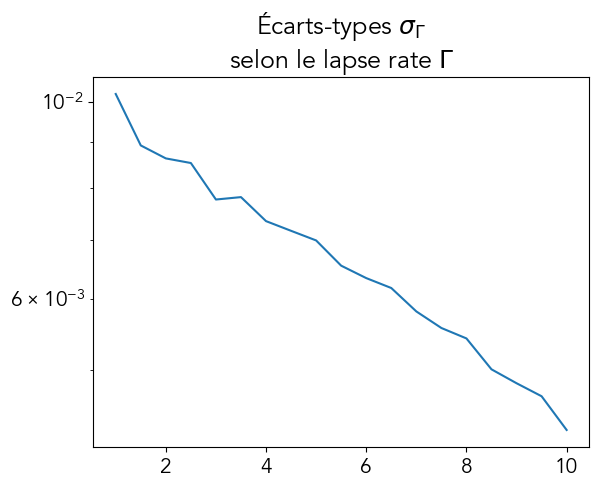

In [38]:
plt.plot(Vstd_array[:,0],Vstd_array[:,1])
plt.title(r"Écarts-types $\sigma_{\Gamma}$"+"\n"+"selon le lapse rate $\Gamma$")
plt.yscale('log')
plt.show()
plt.close()

### Comparaison des "adjusted lapse rate" $\Gamma$ à la réanalyse

In [54]:
rcms_TprofileArray[20]

array([237.19684639, 216.50684348, 211.71943322, 210.2572491 ,
       209.48985819, 209.32623293, 209.46966724, 209.89736508,
       210.81286029, 212.26106572, 214.41124528, 218.39870134,
       223.79740427, 228.89875502, 233.73945527, 238.34950417,
       242.75376929, 246.97311764, 251.02524784, 254.92531412,
       258.68640208, 262.31989694, 265.83577227, 269.24281927,
       272.54883065, 275.76074976, 278.88479243, 281.92654751,
       284.89106035, 287.78290269, 289.20288627])

In [42]:
ncep_lev

array([1000.,  925.,  850.,  700.,  600.,  500.,  400.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   30.,   20.,   10.],
      dtype=float32)

In [43]:
ncep_T

array([288.32907, 284.357  , 280.9883 , 273.36993, 266.70166, 258.26114,
       247.57953, 233.7803 , 226.35208, 219.49774, 212.58644, 206.14395,
       207.61707, 211.66336, 217.2964 , 221.55605, 229.93001],
      dtype=float32)

In [63]:
Ncep_Tz_Prsn=[]
for profil in range(1,21):
    ncep, Tz = ncep_T, rcms_TprofileArray[profil]
    res = stats.pearsonr(ncep,Tz)
    Ncep_Tz_Prsn.append([
        float(Gamma_list[profil].split('-')[1]),
        res.statistic,
        res.pvalue
    ])
Ncep_Tz_Prsn    

31

In [63]:
# Interpoler les données de ncep_T en fonction des niveaux de rcms_TprofileArray (31 niveaux)  
rcm_niv = list(rcm.lev)
#Ajout du niveau de surface (pour matcher avec les niveaux dans rcms_TprofileArray)
rcm_niv.append(1000)
len(rcm_niv)

31

In [64]:
len(rcms_TprofileArray[20,:])

31

In [67]:
#Interpolation linéaire des 31 valeurs désirées avec scipy, à partir des valeurs ncep reanalysis
extrapolation = interpolate.interp1d(ncep_lev,ncep_T,fill_value='extrapolate')

In [68]:
ncep_xtpl = extrapolation(rcm_niv)

In [69]:
ncep_xtpl

array([224.34736617, 211.66336071, 206.96234809, 208.29144791,
       212.58644089, 217.19397495, 221.7825216 , 226.35208139,
       231.3042299 , 236.08017475, 240.67991635, 245.27965795,
       249.35979711, 252.92033371, 256.48087032, 259.66789248,
       262.4813996 , 265.29490672, 267.81303917, 270.03579721,
       272.25855524, 274.2164205 , 275.90939333, 277.60236615,
       279.29533898, 280.98831181, 282.4855042 , 283.98269663,
       285.68102008, 287.44638734, 288.32907097])

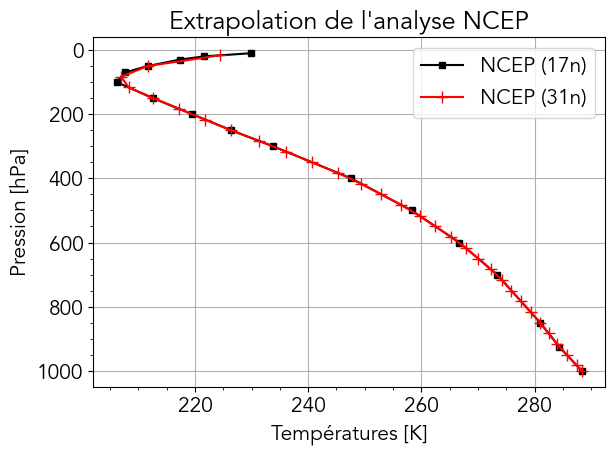

In [144]:
plt.plot(ncep_T,ncep_lev, marker="s", color="black", markersize=4, label="NCEP (17n)")
plt.plot(ncep_xtpl,rcm_niv, marker="+", color="red", markersize=8, label="NCEP (31n)")
plt.gca().invert_yaxis()
plt.title("Extrapolation de l'analyse NCEP")
plt.xlabel("Températures [K]")
plt.ylabel("Pression [hPa]")
plt.grid()
plt.minorticks_on()
plt.legend()
plt.tight_layout()
plt.savefig("./figures/M1Der_stat3_setup.png")
plt.show()

In [72]:
#Les valeurs de ncep_xtpl seront utilisées pour la corrélation avec chaque profil selon la turbulence
Ncep_Tz_Prsn=[]
for profil in range(1,21):
    ncep, Tz = ncep_xtpl, rcms_TprofileArray[profil]
    res = stats.pearsonr(ncep,Tz)
    Ncep_Tz_Prsn.append([
        float(Gamma_list[profil].split('-')[1]),
        res.statistic,
        res.pvalue
    ])
Ncep_Tz_Prsn 

[[0.5, 0.8738463290641612, 1.3772513474188792e-10],
 [1.0, 0.9238624207791057, 1.2668525451358119e-13],
 [1.5, 0.9508771914722041, 2.626276413173537e-16],
 [2.0, 0.9615591096855036, 8.037322703579705e-18],
 [2.5, 0.9668080054802421, 9.890457120304738e-19],
 [3.0, 0.97902783575547, 1.3739719976699348e-21],
 [3.5, 0.9865838233870441, 2.2164000893624114e-24],
 [4.0, 0.9930600195104872, 1.6314215274058076e-28],
 [4.5, 0.9963611077910317, 1.4321842279434905e-32],
 [5.0, 0.9969681945361986, 1.0192535529570509e-33],
 [5.5, 0.9954556348546828, 3.5712451569945978e-31],
 [6.0, 0.9919147970639328, 1.4833337597498694e-27],
 [6.5, 0.9866307511233345, 2.1072308611032174e-24],
 [7.0, 0.980094418141915, 6.4899020321219125e-22],
 [7.5, 0.9724865055468184, 6.751974759191342e-20],
 [8.0, 0.9638701597015616, 3.3197718291871605e-18],
 [8.5, 0.9548699375122682, 7.882662403333046e-17],
 [9.0, 0.9453574296000655, 1.1869782393135342e-15],
 [9.5, 0.9353420688121674, 1.2765797734862611e-14],
 [10.0, 0.9255807343

In [80]:
# Calculs des scores de changements entre les profils et ncep, normalisés par rapport à ncep
ncep_Tz_sc=[]
ncep_xtpl_array = np.array(ncep_xtpl)
for profil in range(1,21):
    rcm_i = np.array(rcms_TprofileArray[profil])
    
    mean_scoreChg = np.mean(
        abs((rcms_TprofileArray[profil]-ncep_xtpl_array)/ncep_xtpl_array)
    )
    
    ncep_Tz_sc.append([
        float(Gamma_list[profil].split('-')[1]),
         mean_scoreChg
    ])
ncep_Tz_sc = np.array(ncep_Tz_sc)
ncep_Tz_sc

array([[ 0.5       ,  0.0871143 ],
       [ 1.        ,  0.07824865],
       [ 1.5       ,  0.06960876],
       [ 2.        ,  0.06089579],
       [ 2.5       ,  0.05199857],
       [ 3.        ,  0.04365917],
       [ 3.5       ,  0.03529524],
       [ 4.        ,  0.02765485],
       [ 4.5       ,  0.02067026],
       [ 5.        ,  0.01481555],
       [ 5.5       ,  0.01124247],
       [ 6.        ,  0.01296813],
       [ 6.5       ,  0.01813997],
       [ 7.        ,  0.02332331],
       [ 7.5       ,  0.02831772],
       [ 8.        ,  0.03324272],
       [ 8.5       ,  0.0378323 ],
       [ 9.        ,  0.04223299],
       [ 9.5       ,  0.04646921],
       [10.        ,  0.05033851]])

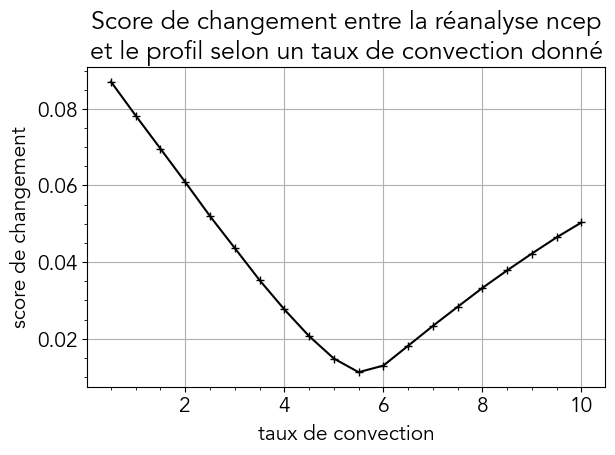

In [142]:
plt.plot(ncep_Tz_sc[:,0],ncep_Tz_sc[:,1], marker="+", color="black")
plt.title('Score de changement entre la réanalyse ncep\net le profil selon un taux de convection donné')
plt.xlabel('taux de convection')
plt.ylabel('score de changement')
plt.grid()
plt.minorticks_on()
plt.tight_layout()
plt.savefig("./figures/M1Der_stat3.png",dpi=300)

plt.show()